## Vehicle Detection

In [262]:
import numpy as np
import pandas as pd
import cv2
import glob

from scipy.ndimage.measurements import label

from skimage.feature import hog
from skimage import color, exposure

from sklearn.svm import LinearSVC, SVC
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

from lesson_functions import *

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

First of all, the training images are read:

In [263]:
nonvehicles = pd.DataFrame(glob.glob('./non-vehicles/non-vehicles/*/*.png'), columns=['image'])
nonvehicles['label'] = 0

vehicles = pd.DataFrame(glob.glob('./vehicles/vehicles/*/*.png'), columns=['image'])
vehicles['label'] = 1

In [264]:
print('Number of vehicle samples is:')
print(vehicles['image'].shape[0])
print('Number of nonvehicle samples is: ')
print(nonvehicles['image'].shape[0])
print('Shape of an image is:')
print(mpimg.imread(vehicles['image'].iloc[0]).shape)

Number of vehicle samples is:
8792
Number of nonvehicle samples is: 
8968
Shape of an image is:
(64, 64, 3)


And two examples (one for vehicle samples, one for non-vehicle samples) are read:

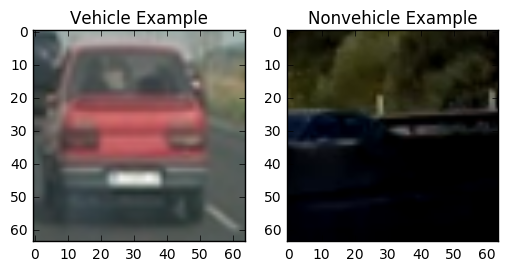

In [265]:
vehicle_sample = mpimg.imread(vehicles['image'].iloc[400])
nonvehicle_sample = mpimg.imread(nonvehicles['image'].iloc[400])
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(vehicle_sample)
ax1.set_title('Vehicle Example')
ax2.imshow(nonvehicle_sample)
ax2.set_title('Nonvehicle Example')

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

A helper function named "get_hog_features" is used for extracting HOG features:

In [266]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

And here is an example of the hog image output for a vehicle and a nonvehicle image, for each color channel:

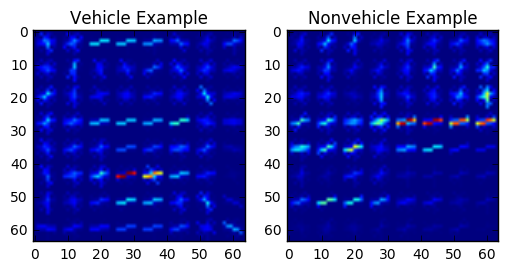

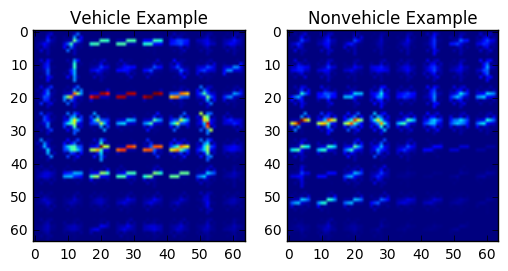

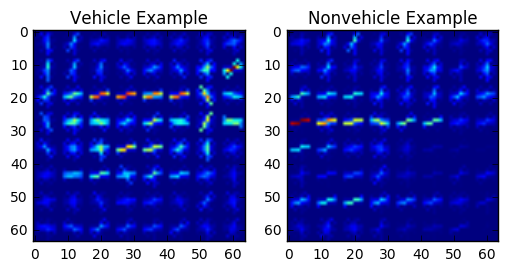

In [267]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
vis = True
vehicle_sample = cv2.cvtColor(vehicle_sample, cv2.COLOR_RGB2YCrCb)
nonvehicle_sample = cv2.cvtColor(nonvehicle_sample, cv2.COLOR_RGB2YCrCb)
for channel in range(0, 3):
    _, vehicle_hog = get_hog_features(vehicle_sample[:,:,channel], orient, pix_per_cell, cell_per_block, vis=vis)
    _, nonvehicle_hog = get_hog_features(nonvehicle_sample[:,:,channel], orient, pix_per_cell, cell_per_block, vis=vis)

    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(vehicle_hog)
    ax1.set_title('Vehicle Example')
    ax2.imshow(nonvehicle_hog)
    ax2.set_title('Nonvehicle Example')

#### 2. Explain how you settled on your final choice of HOG parameters.

I experimented with many different color spaces and channels, and I am ended up with the YCrCb color space.

HSV was a good candidate too, but with YCrCb, I had a slightly better performance on the video.

In orientations and pixels per cell, I tried various options between certain ranges (6 to 10 for orientations, for example) and decided that 9 orientations and 8x8 pixel per cell was of the optimal result, as it is intuitively plausible.

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I used spatial bins and color histograms together with the HOG features.

The helper functions for extracting these features are below:

In [268]:
# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

And the training parameters are defined here:

In [269]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

Here, the features (hog, spatial, histogram) are extracted from the data:

In [270]:
car_features = extract_features(vehicles['image'], color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(nonvehicles['image'], color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

KeyboardInterrupt: 

The vehicle and nonvehicle features are stacked together and scaled:

In [271]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

Also, their labels (1 for vehicles, 0 for nonvehicles) are stacked:

In [272]:
y = np.hstack((vehicles['label'], nonvehicles['label']))

Both shuffling and train-test splitting is made by using sklearn's train_test_split function:

In [273]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)

As the support vector classifier, LinearSVC() is used since using SVC witf 'rbf' didn't improve the performance so much, and considering its large difference in terms of speed, LinearSVC() is decided to be used.

In [274]:
svc = LinearSVC()

svc.fit(X_train, y_train)

accuracy = svc.score(X_test, y_test)
print("Accuracy of the support vector classifier is: ", accuracy)

Accuracy of the support vector classifier is:  0.992961711712


In [275]:
# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def add_heat(heatmap, box):
    # for box in bbox_list:
    heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bboxes =[]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, bboxes

In [276]:
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

In [277]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [278]:
y_start_stop = [400, 660]
xy_overlap = (0.5, 0.5)
xy_window = (64, 64)
scale = 1.4

In [ ]:
search_path = './test_images/*'
test_images = glob.glob(search_path)
images = []
titles = []
for image in test_images:
    image = mpimg.imread(image)
    draw_image = np.copy(image)

    image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=xy_window, xy_overlap=(xy_overlap)

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    images.append(window_img)
    titles.append(' ')
    
fig = plt.figure(figsize=(12, 18), dpi=300)
visualize(fig, 5, 2, images, titles)

In [242]:
def find_cars(img, scale):
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255
    
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float32)
    
    img_tosearch = img[ystart:ystop,:,:]
    
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    
    window = xy_window[0]
    
    nblocks_per_window = window // pix_per_cell - 1
    
    cells_per_step = 2
    
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            test_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(test_features)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart), (0, 0, 255), 6)
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1

    return draw_img, heatmap

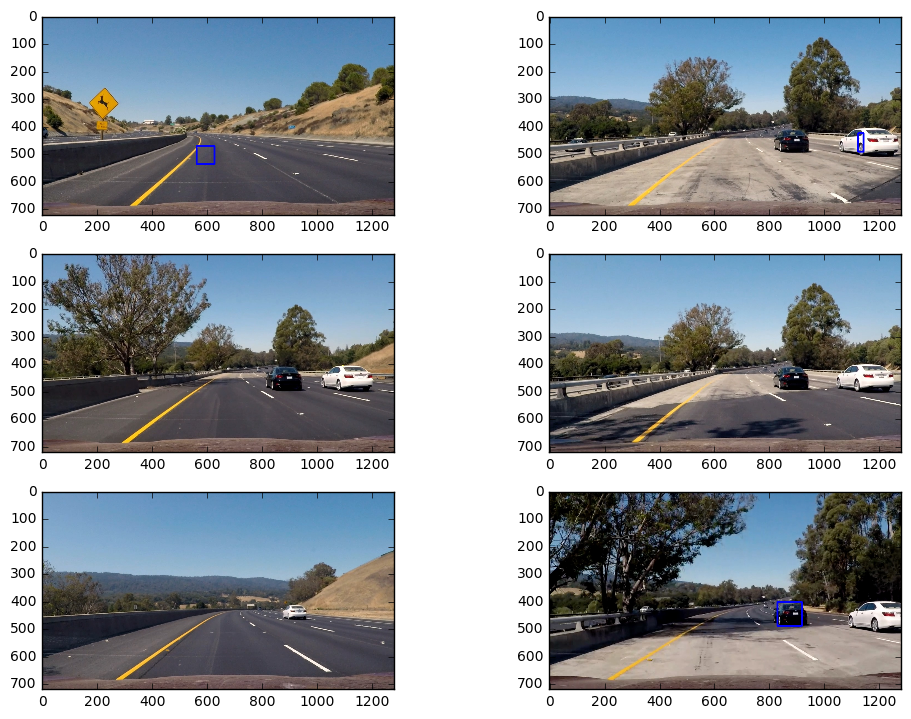

In [243]:
out_images = []
out_titles = []
search_path = './test_images/*'
test_images = glob.glob(search_path)
for img_path in test_images:
    image = mpimg.imread(img_path)
    out_img, heat_map = find_cars(image, scale)
    heat_map = apply_threshold(heat_map, 1)
    labels = label(heat_map)
    out_img, _ = draw_labeled_bboxes(np.copy(image), labels)
    out_images.append(out_img)
    
    out_titles.append(' ')
    out_titles.append(' ')
fig = plt.figure(figsize=(12, 24))
visualize(fig, 8, 2, out_images, out_titles)

In [202]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [203]:
class Vehicle:
    def __init__(self):
        self.detected = False
        self.n_detections = 0
        self.n_nondetections = 0
        self.xpixels = None
        self.ypixels = None
        self.recent_xfitted = []
        self.recent_yfitted = []
        self.bestx = None
        self.besty = None
        self.recent_wfitted = []
        self.bestw = None
        self.recent_hfitted = []
        self.besth = []
        self.buffer = 25
        
    def update_fits(self, box):
        self.recent_xfitted.append((bbox[0][0] + bbox[1][0]) / 2)
        self.recent_yfitted.append((bbox[0][1] + bbox[1][1]) / 2)
        self.recent_wfitted.append(abs(bbox[1][0] - bbox[0][0]))
        self.recent_hfitted.append(abs(bbox[1][1] - bbox[0][1]))
        
        if len(self.recent_xfitted) > self.buffer:
            self.recent_xfitted = self.recent_xfitted[1:]
        if len(self.recent_yfitted) > self.buffer:
            self.recent_yfitted = self.recent_yfitted[1:]
        
        if len(self.recent_wfitted) > self.n:
            self.recent_wfitted = self.recent_wfitted[1:]
        if len(self.recent_hfitted) > self.n:
            self.recent_hfitted = self.recent_hfitted[1:]
        
        self.bestx = int(np.mean(self.recent_xfitted))
        self.besty = int(np.mean(self.recent_yfitted))
        
        self.bestw = int(np.mean(self.recent_wfitted))
        self.besth = int(np.mean(self.recent_hfitted))

In [204]:
def find_cars_video(img, scale):
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255
    
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float32)
    
    img_tosearch = img[ystart:ystop,:,:]
    
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    
    window = xy_window[0]
    
    nblocks_per_window = window // pix_per_cell - 1
    
    cells_per_step = 2
    
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            test_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(test_features)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart), (0, 0, 255), 6)
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1

    return draw_img, heatmap

In [205]:
def process_frame(image):
    draw_image = np.copy(image)
    out_image, heat_map = find_cars_video(draw_image, scale)
    heat_map = apply_threshold(heat_map, 1)
    labels = label(heat_map)
    out_img, _ = draw_labeled_bboxes(draw_image, labels)
    
    return out_img

In [206]:
video_output = "output1.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_frame)
%time clip.write_videofile(video_output, audio=False)

ValueError: operands could not be broadcast together with shapes (1,8460) (4932,) (1,8460) 

In [169]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))